# Price Predictions with Machine Learning

### Import libraries

In [75]:
# imports
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import xgboost as xgb

# initial xgboost install
#import sys
#!{sys.executable} -m pip install xgboost

### Load Data

In [136]:
train = pd.read_csv('./train.csv', index_col='Id')
test = pd.read_csv('./test.csv', index_col='Id')

In [137]:
# drop outliers later discovered in the PreProcessing section
# see PreProcessing notes for details
train = train.drop(train[(train.OverallQual == 10) & (train.SalePrice < 200000)].index)
#train = train.drop(train[(train.SalePrice > 700000)].index)
# dropping 700000 improved the training set, but lowered test predictions

In [138]:
train.shape

(1458, 80)

In [139]:
test.shape

(1459, 79)

In [140]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [141]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### Set up Training and Validation Data

In [142]:
y = train['SalePrice']
features = train.drop(['SalePrice'], axis=1)

In [143]:
X_train, X_valid, y_train, y_valid = train_test_split(
    features, y, train_size=0.8, test_size=0.2, random_state=0)

### Exploratory Data Analysis

In [144]:
pd.set_option('display.max_columns', None)
X_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1166.000000,963.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1159.00000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1104.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000
mean,56.346484,70.015576,10533.533448,6.084906,5.580617,1970.444254,1984.520583,96.99396,430.548885,46.079760,570.856775,1047.485420,1153.655232,354.815609,6.180961,1514.651801,0.409091,0.057461,1.560892,0.387650,2.888508,1.044597,6.538593,0.612350,1977.905797,1.759863,468.794168,92.109777,46.408233,22.979417,2.722985,15.564322,2.103774,44.248714,6.343053,2007.830189
std,41.740420,22.983832,10642.582453,1.349803,1.117908,30.608898,20.711196,176.89881,431.551538,160.558557,433.731373,410.622148,370.796696,433.772515,50.028600,500.756885,0.512390,0.240082,0.545899,0.501313,0.782593,0.218620,1.569496,0.650376,24.793548,0.738146,209.592690,123.804040,66.107843,63.311096,26.313259,56.162048,36.234293,495.303044,2.700942,1.338238
min,20.000000,21.000000,1477.000000,1.000000,1.000000,1872.000000,1950.000000,0.00000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,60.000000,7590.000000,5.000000,5.000000,1953.000000,1966.000000,0.00000,0.000000,0.000000,245.000000,796.000000,874.250000,0.000000,0.000000,1140.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,326.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9475.000000,6.000000,5.000000,1972.000000,1993.000000,0.00000,370.500000,0.000000,486.000000,979.500000,1079.000000,0.000000,0.000000,1470.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,474.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11500.000000,7.000000,6.000000,2000.000000,2004.000000,149.00000,701.500000,0.000000,808.000000,1264.000000,1382.750000,729.750000,0.000000,1778.250000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.00000,2188.000000,1474.000000,2046.000000,3206.000000,3228.000000,2065.000000,572.000000,4476.000000,3.000000,2.000000,3.000000,2.000000,6.000000,3.000000,12.000000,3.000000,2010.000000,4.000000,1390.000000,736.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


###### Check for missing values.

In [145]:
Missing_values = X_train.isnull().sum()
Missing_values = Missing_values[Missing_values != 0].sort_values(ascending=False)

In [146]:
# plot 
h_bar = px.bar(x = Missing_values.values, y = Missing_values.index, orientation='h')
h_bar.show()

###### Identify Columns

In [147]:
# identify categorical columns
categorical_cols = [col_name for col_name in X_train.columns if
                    X_train[col_name].nunique() < 100 and
                    X_train[col_name].dtype == "object"]

# identify numerical columns
numerical_cols = [col_name for col_name in X_train.columns if 
                X_train[col_name].dtype in ['int64', 'float64']]

# combine categorical and numerical columns
my_cols = (categorical_cols + numerical_cols)
X_train = X_train[my_cols].copy()
X_valid = X_valid[my_cols].copy()
test = test[my_cols].copy()

###### Correlation of features

<AxesSubplot:>

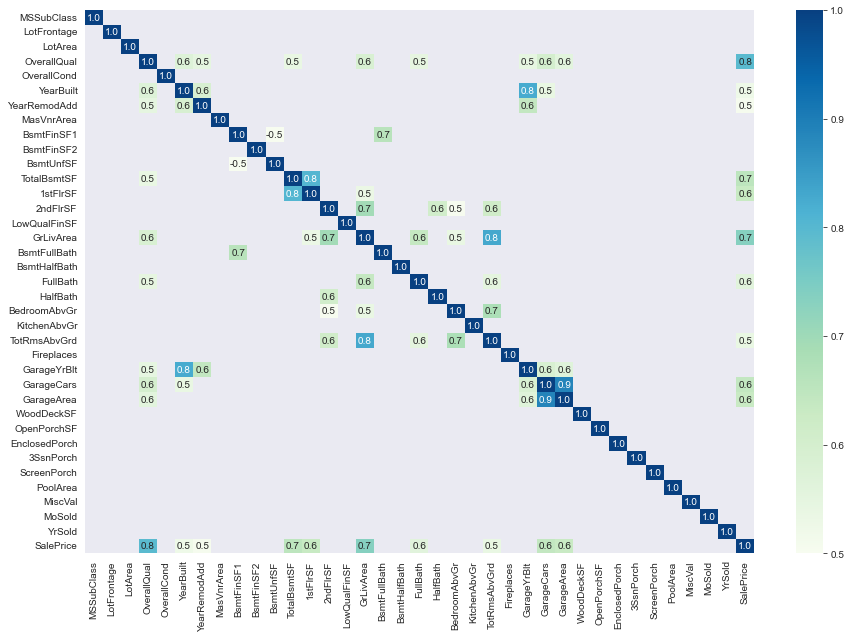

In [148]:
sns.set_style('darkgrid')
plt.figure(figsize=(15, 10))
corr = train[numerical_cols+['SalePrice']].corr()
high_corr = corr[abs(corr) >= 0.5]
sns.heatmap(high_corr,
            annot=True,
            fmt='.1f',
            cmap='GnBu',
            vmin=0.5,
            vmax=1)

In [149]:
corr['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.795774
GrLivArea        0.734968
TotalBsmtSF      0.651153
GarageCars       0.641047
1stFlrSF         0.631530
GarageArea       0.629217
FullBath         0.562165
TotRmsAbvGrd     0.537769
YearBuilt        0.523608
YearRemodAdd     0.507717
GarageYrBlt      0.487156
MasVnrArea       0.482719
Fireplaces       0.469862
BsmtFinSF1       0.409384
LotFrontage      0.370584
WoodDeckSF       0.324758
OpenPorchSF      0.321142
2ndFlrSF         0.320532
HalfBath         0.284590
LotArea          0.268179
BsmtFullBath     0.228459
BsmtUnfSF        0.214460
BedroomAbvGr     0.168245
ScreenPorch      0.111415
PoolArea         0.099490
MoSold           0.046124
3SsnPorch        0.044568
BsmtFinSF2      -0.011422
BsmtHalfBath    -0.016881
MiscVal         -0.021203
LowQualFinSF    -0.025625
YrSold          -0.028882
OverallCond     -0.077948
MSSubClass      -0.084276
EnclosedPorch   -0.128646
KitchenAbvGr    -0.135946
Name: SalePrice, dtype: float64

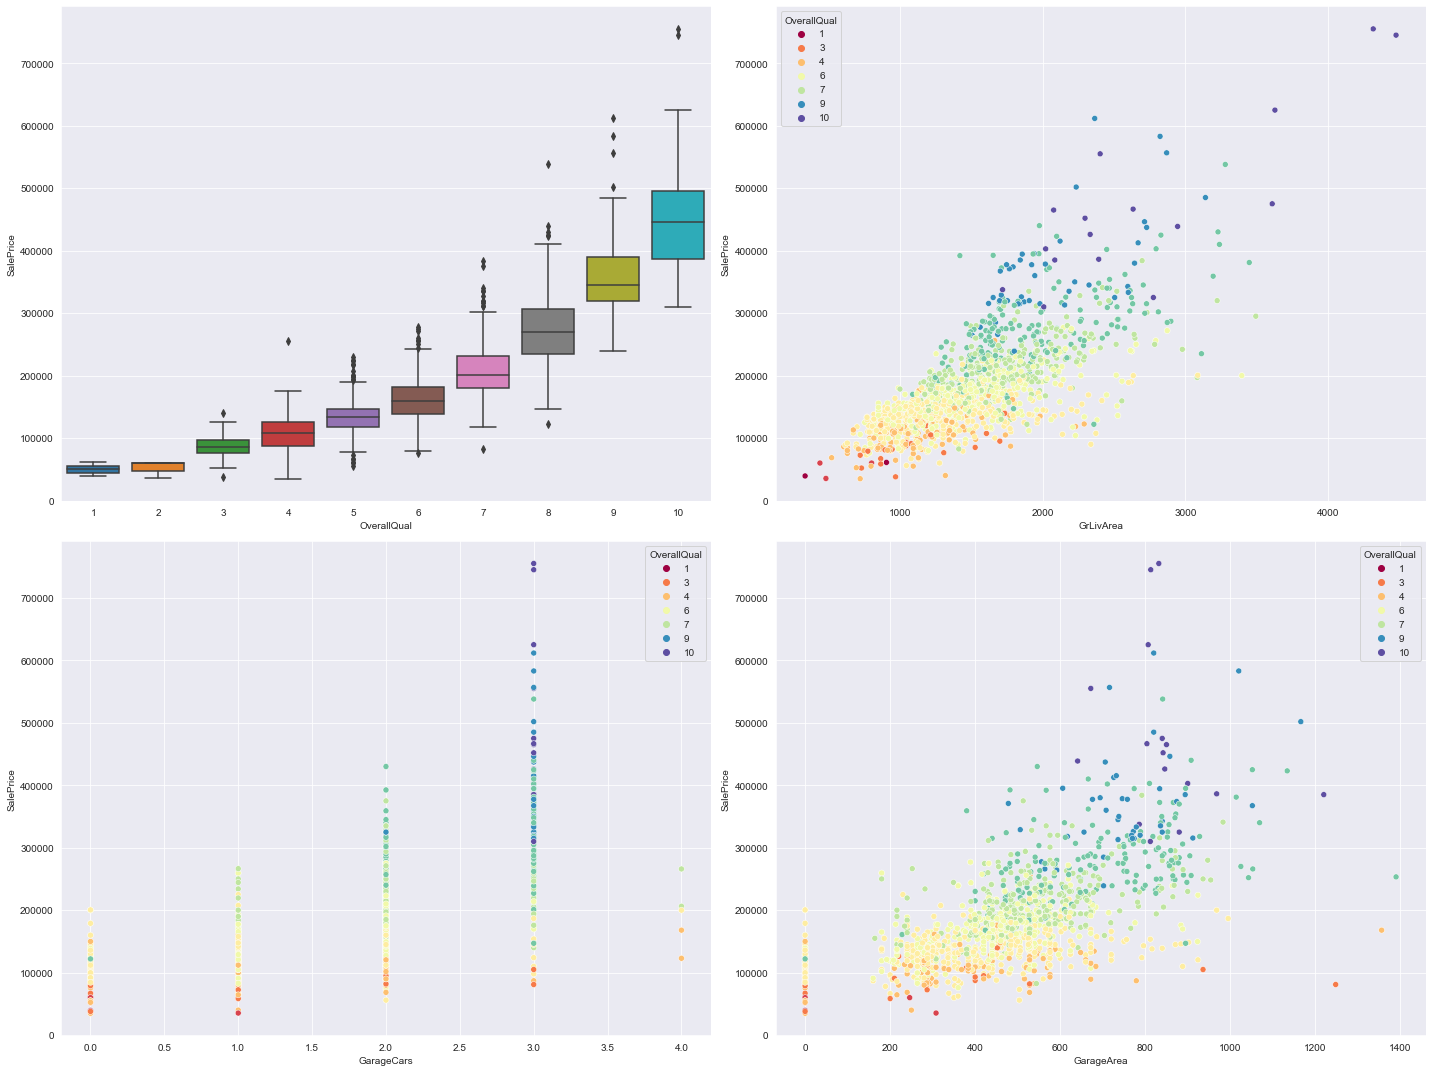

In [150]:
fig = plt.figure(figsize=(20, 15))

fig1 = fig.add_subplot(221); 
sns.boxplot(x='OverallQual', y='SalePrice', data=train[['SalePrice', 'OverallQual']])

fig2 = fig.add_subplot(222); 
sns.scatterplot(x = train.GrLivArea, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

fig3 = fig.add_subplot(223); 
sns.scatterplot(x = train.GarageCars, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

fig4 = fig.add_subplot(224); 
sns.scatterplot(x = train.GarageArea, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

plt.tight_layout(); plt.show()

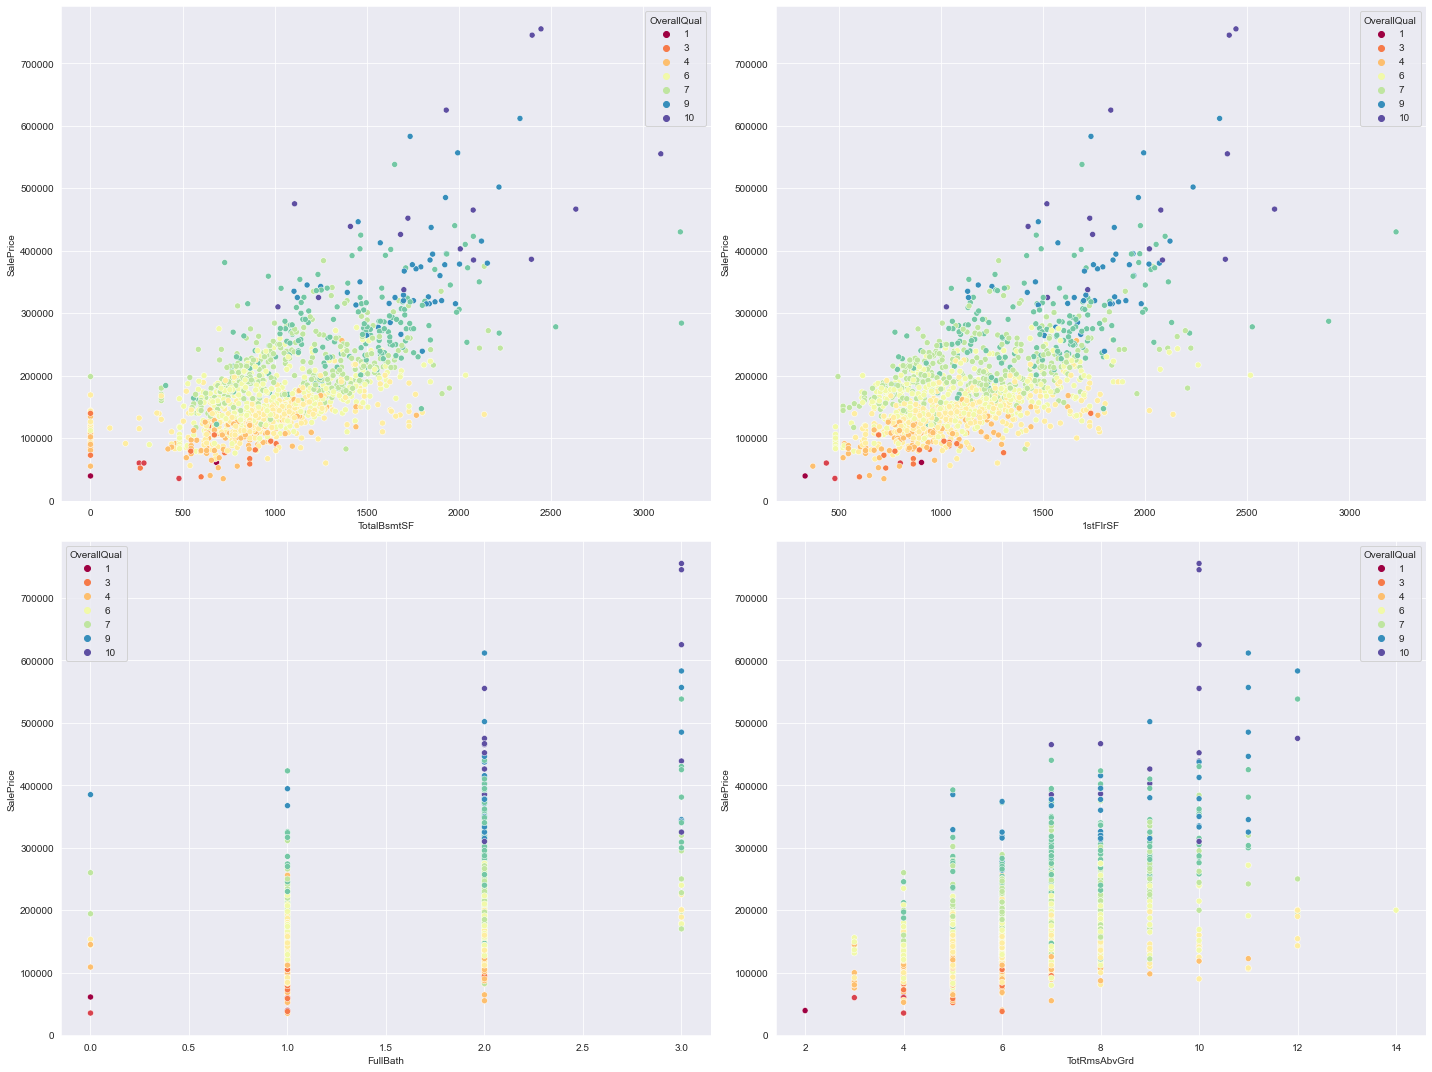

In [151]:
fig = plt.figure(figsize=(20, 15))

fig5 = fig.add_subplot(221); 
sns.scatterplot(y = train.SalePrice , x = train.TotalBsmtSF, hue=train.OverallQual, palette= 'Spectral')

fig6 = fig.add_subplot(222); 
sns.scatterplot(y = train.SalePrice, x = train['1stFlrSF'], hue=train.OverallQual, palette= 'Spectral')

fig7 = fig.add_subplot(223); 
sns.scatterplot(x = train.FullBath, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

fig8 = fig.add_subplot(224); 
sns.scatterplot(x = train.TotRmsAbvGrd, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

plt.tight_layout(); plt.show()


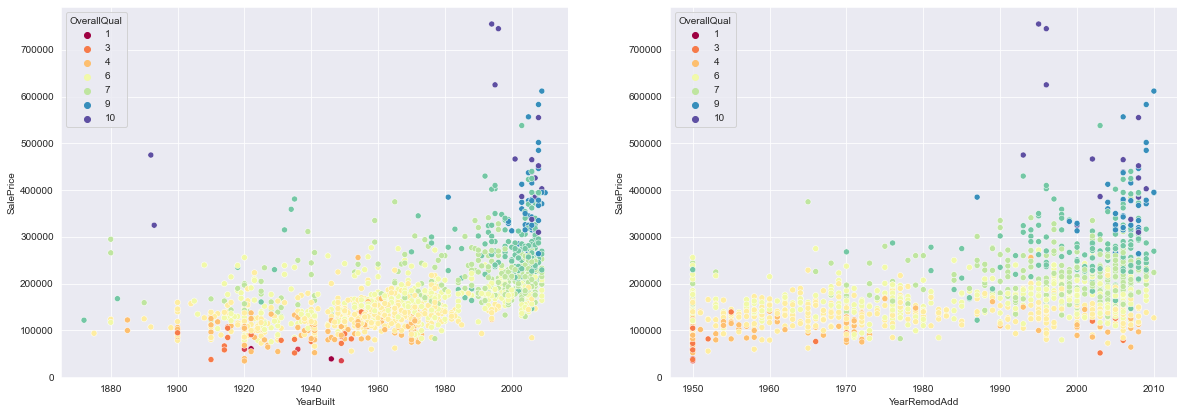

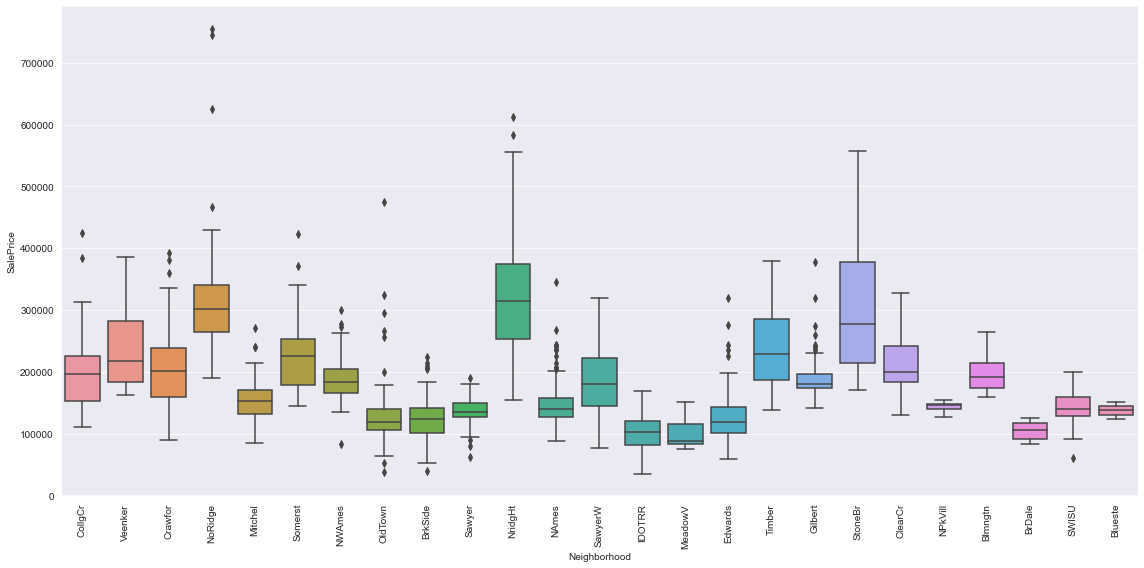

In [152]:
fig = plt.figure(figsize=(20, 15))

fig9 = fig.add_subplot(221); 
sns.scatterplot(x = train.YearBuilt, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

fig10 = fig.add_subplot(222); 
sns.scatterplot(x = train.YearRemodAdd, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

fig12 = plt.figure(figsize=(16, 8)); 
plt.xticks(rotation=90)
sns.boxplot(x='Neighborhood', y='SalePrice', data=train[['SalePrice', 'Neighborhood']])

plt.tight_layout(); plt.show()

### PreProcessing

In [153]:
# identify outliers
# quality 10 with SalePrice < 200000
outliers1 = train[(train.OverallQual == 10) & (train.SalePrice < 200000)]

# GrLivArea > 4000 SalePrice < 200000
outliers2 = train[(train.GrLivArea  > 4000) & (train.SalePrice < 200000)]

# TotalBsmtSF > 6000 with SalePrice < 200000
outliers3 = train[(train.TotalBsmtSF > 6000) & (train.SalePrice < 200000)]

# SalePrice > 700000
outliers4 = train[(train.SalePrice < 200000)]

# 4 houses were identified and will be excluded
# we will need to drop these outliers from the inital 'train' data set as 'X_train' does not contain 'SalePrice'
# note that we will not see these outliers when revisiting this step as they are now removed


In [154]:
# numerical columns that are not applicable set to zero
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    X_train[col] = X_train[col].fillna(0)
    X_valid[col] = X_valid[col].fillna(0)
    test[col] = test[col].fillna(0)

In [155]:
# fill in columns that are null with 'none'
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
            'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    X_train[col] = X_train[col].fillna('None')
    X_valid[col] = X_valid[col].fillna('None')
    test[col] = test[col].fillna('None')

In [156]:
# remove columns with low impact
X_train = X_train.drop(['Utilities', 'Street', 'PoolQC'], axis=1)
X_valid = X_valid.drop(['Utilities', 'Street', 'PoolQC'], axis=1)
test = test.drop(['Utilities', 'Street', 'PoolQC'], axis=1)

In [157]:
# create new features
X_train['YrBltAndRemod'] = X_train['YearBuilt'] + X_train['YearRemodAdd']
X_valid['YrBltAndRemod'] = X_valid['YearBuilt'] + X_valid['YearRemodAdd']
test['YrBltAndRemod'] = test['YearBuilt'] + test['YearRemodAdd']


X_train['TotalSF_finished'] = X_train['TotalBsmtSF'] + X_train['1stFlrSF'] + X_train['2ndFlrSF']
X_valid['TotalSF_finished'] = X_valid['TotalBsmtSF'] + X_valid['1stFlrSF'] + X_valid['2ndFlrSF']
test['TotalSF_finished'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']


X_train['TotalSF_all'] = (X_train['BsmtFinSF1'] + X_train['BsmtFinSF2'] +
                                 X_train['1stFlrSF'] + X_train['2ndFlrSF'])
X_valid['TotalSF_all'] = (X_valid['BsmtFinSF1'] + X_valid['BsmtFinSF2'] +
                                 X_valid['1stFlrSF'] + X_valid['2ndFlrSF'])
test['TotalSF_all'] = (test['BsmtFinSF1'] + test['BsmtFinSF2'] +
                                 test['1stFlrSF'] + test['2ndFlrSF'])


X_train['Total_Bathrooms'] = (X_train['FullBath'] + (0.5 * X_train['HalfBath']) +
                               X_train['BsmtFullBath'] + (0.5 * X_train['BsmtHalfBath']))
X_valid['Total_Bathrooms'] = (X_valid['FullBath'] + (0.5 * X_valid['HalfBath']) +
                               X_valid['BsmtFullBath'] + (0.5 * X_valid['BsmtHalfBath']))
test['Total_Bathrooms'] = (test['FullBath'] + (0.5 * test['HalfBath']) +
                               test['BsmtFullBath'] + (0.5 * test['BsmtHalfBath']))


X_train['Total_porch_sf'] = (X_train['OpenPorchSF'] + X_train['3SsnPorch'] +
                              X_train['EnclosedPorch'] + X_train['ScreenPorch'] +
                              X_train['WoodDeckSF'])
X_valid['Total_porch_sf'] = (X_valid['OpenPorchSF'] + X_valid['3SsnPorch'] +
                              X_valid['EnclosedPorch'] + X_valid['ScreenPorch'] +
                              X_valid['WoodDeckSF'])
test['Total_porch_sf'] = (test['OpenPorchSF'] + test['3SsnPorch'] +
                              test['EnclosedPorch'] + test['ScreenPorch'] +
                              test['WoodDeckSF'])

In [158]:
# Preprocessing remaining null values in numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Preprocessing remaining null values in categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),   
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# update numerical/categorical columns due to adding/removing columns
categorical_cols_2 = [col_name for col_name in X_train.columns if
                    X_train[col_name].nunique() < 1000 and
                    X_train[col_name].dtype == "object"]

numerical_cols_2 = [col_name for col_name in X_train.columns if 
                X_train[col_name].dtype in ['int64', 'float64']]

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols_2),
        ('cat', categorical_transformer, categorical_cols_2)
    ])

### Build the Initial Model and Evaluate

In [159]:
# define the model
model_1 = XGBRegressor(random_state=0)

In [160]:
pipeline_1 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model_1)
                             ])

# Preprocessing of training data, fit model 
pipeline_1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                 

In [161]:
# view pipeline onehot tranformations
pipeline_1['preprocessor'].transformers_[1][1]\
    ['onehot'].get_feature_names_out(categorical_cols_2)

array(['MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Alley_Grvl', 'Alley_Pave', 'LotShape_IR1',
       'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk',
       'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl',
       'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2',
       'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Gtl',
       'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blmngtn',
       'Neighborhood_Blueste', 'Neighborhood_BrDale',
       'Neighborhood_BrkSide', 'Neighborhood_ClearCr',
       'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_IDOTRR', 'Neighborhood_MeadowV',
       'Neighborhood_Mitchel', 'Neighborhood_NAmes',
       'Neighborhood_NPkVill', 'Neighborhood_NWAmes',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighborhood_SWISU',
       'Neighborhood_Sawyer', 'Neighborhood_S

In [162]:
# Preprocessing of validation data, get predictions
predictions_1 = pipeline_1.predict(X_valid)

In [163]:
# calculate MAE
mae_1 = mean_absolute_error(predictions_1, y_valid)
print("Mean Absolute Error:" , mae_1)

Mean Absolute Error: 15593.363441780823


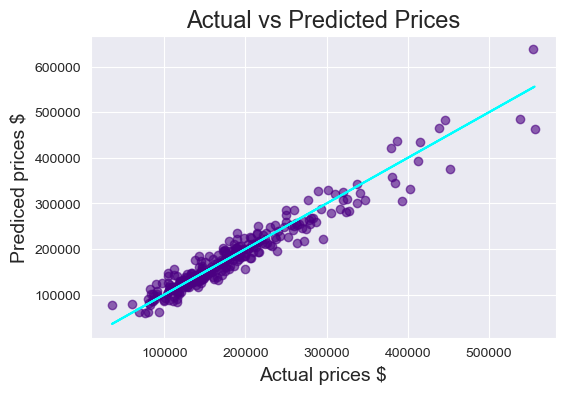

In [164]:
residuals = (y_valid - predictions_1)

plt.figure(dpi=100)
plt.scatter(x=y_valid, y=predictions_1, c='indigo', alpha=0.6)
plt.plot(y_valid, y_valid, color='cyan')
plt.title(f'Actual vs Predicted Prices', fontsize=17)
plt.xlabel('Actual prices $', fontsize=14)
plt.ylabel('Prediced prices $', fontsize=14)
plt.show()


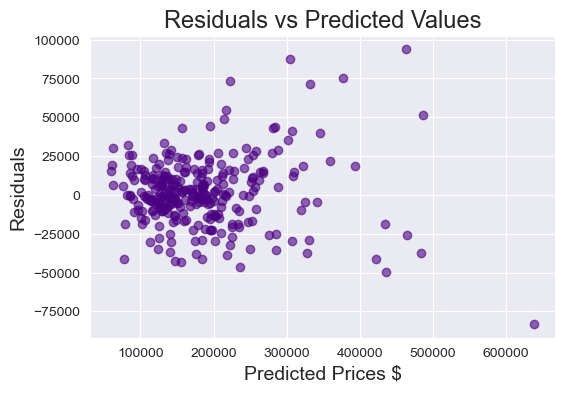

In [165]:
plt.figure(dpi=100)
plt.scatter(x=predictions_1, y=residuals, c='indigo', alpha=0.6)
plt.title('Residuals vs Predicted Values', fontsize=17)
plt.xlabel('Predicted Prices $', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.show()

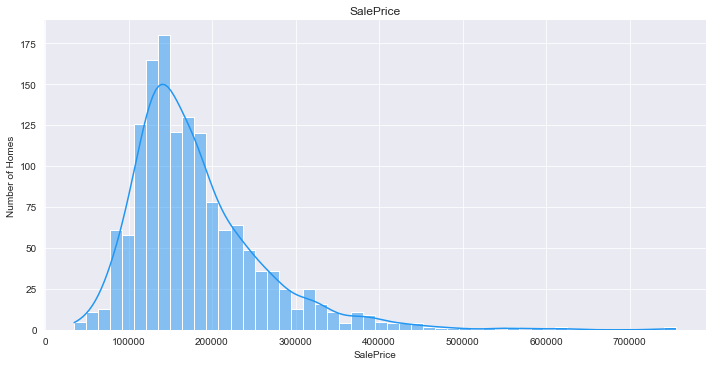

In [166]:
sns.displot(y, 
            bins=50, 
            aspect=2,
            kde=True, 
            color='#2196f3')

plt.title('SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Number of Homes')

plt.show()

### Refine the Model

A couple of observations from reviewing the initial results:
1) It is possible that a log transformation of 'SalePrice' may improve results
2) There are a few outliers that should be reviewed and potentially dropped from training set
3) Model parameters can likely be improved

In [167]:
y_log = np.log(1+y)
#1 + y because log 0 = na

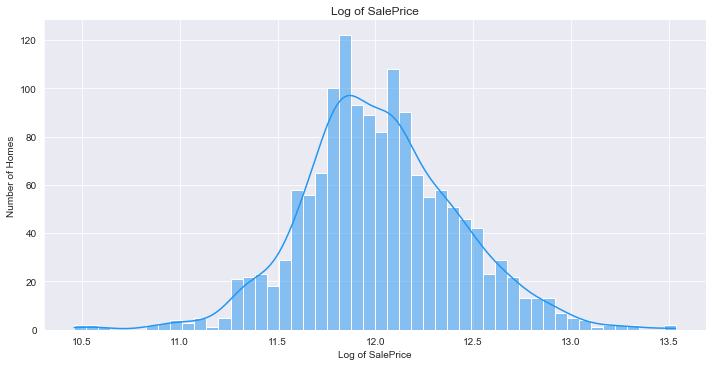

In [168]:
sns.displot(y_log, 
            bins=50, 
            aspect=2,
            kde=True, 
            color='#2196f3')

plt.title('Log of SalePrice')
plt.xlabel('Log of SalePrice')
plt.ylabel('Number of Homes')

plt.show()

In [169]:
y_log_train = np.log(y_train)
y_log_valid = np.log(y_valid)

In [130]:
# model tuning

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, make_scorer# Define our search space for grid search
from sklearn.preprocessing import LabelEncoder


# prevents error
le = LabelEncoder()

# set up grid
grid_pipeline = Pipeline([
  ('preprocessor', preprocessor),
  ('fs', SelectKBest()),
  ('clf', xgb.XGBRegressor(objective='reg:squarederror'))
])

# reasonable values:
#    max_depth: 3–10
#    n_estimators: 100 if big data size, 2000 medium size, 4000 small size
#    learning_rate: 0.01–0.3
#    colsample_bytree: 0.5–1
#    subsample: 0.6–1
#    min_child_weight=0
#    gamma: 0-0.3
#    reg_alpha=0.0001-0.4

search_space = [
  {
    'clf__max_depth': range(3, 10),
    'clf__n_estimators': [2000, 2500, 3000, 3500],
    'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],  
    'clf__colsample_bytree': [i/10.0 for i in range(5, 10)],
    'clf__subsample': [(.8)],
    'clf__min_child_weight': [(0)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'clf__reg_alpha': [(0.0001)]
# add this back for different model types:
#    'fs__score_func': [chi2],
#    'fs__k': [10],
  }
]

# define cross validation
kfold = KFold(n_splits=2)
scoring = 'neg_mean_squared_error'

# Define grid search
grid = GridSearchCV(
  grid_pipeline,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  verbose=1,
  n_jobs=-1
)

# Fit grid search
grid_model = grid.fit(X_train, le.fit_transform(y_train))
print('Best Score: {}'.format(grid_model.best_score_))
print('neg_mean_squared_error: {}')
print(grid_model.best_params_)

In [170]:
model_2 = XGBRegressor(random_state=0, learning_rate=0.01,n_estimators=3500,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1,
                                     reg_alpha=0.0001)

# save best performing model below during tuning attempts
# model_2 = XGBRegressor(random_state=0, learning_rate=0.01,n_estimators=3460,
#                                      max_depth=3, min_child_weight=0,
#                                      gamma=0, subsample=0.7,
#                                      colsample_bytree=0.7,
#                                      objective='reg:squarederror', nthread=-1,
#                                      scale_pos_weight=1, seed=27,
#                                      reg_alpha=0.00006)

In [171]:
pipeline_2 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model_2)
                             ])

# Preprocessing of training data, fit model 
pipeline_2.fit(X_train, y_log_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                 

In [172]:
# Get predictions
predictions_2 = pipeline_2.predict(X_valid)

In [173]:
# calculate MAE
mae_2 = mean_absolute_error(np.exp(predictions_2), np.exp(y_log_valid))
print("Mean Absolute Error:" , mae_2)

Mean Absolute Error: 13499.675393300502


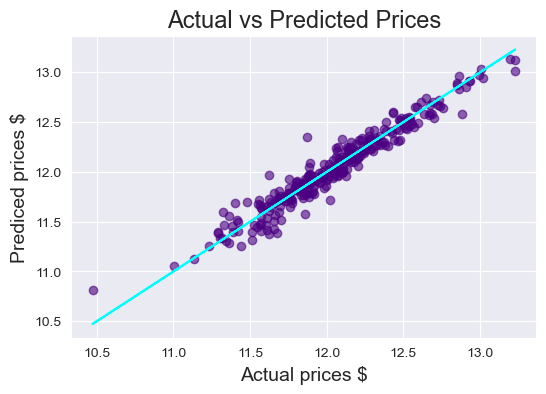

In [174]:
residuals2 = (y_log_valid - predictions_2)

plt.figure(dpi=100)
plt.scatter(x=y_log_valid, y=predictions_2, c='indigo', alpha=0.6)
plt.plot(y_log_valid, y_log_valid, color='cyan')
plt.title(f'Actual vs Predicted Prices', fontsize=17)
plt.xlabel('Actual prices $', fontsize=14)
plt.ylabel('Prediced prices $', fontsize=14)
plt.show()

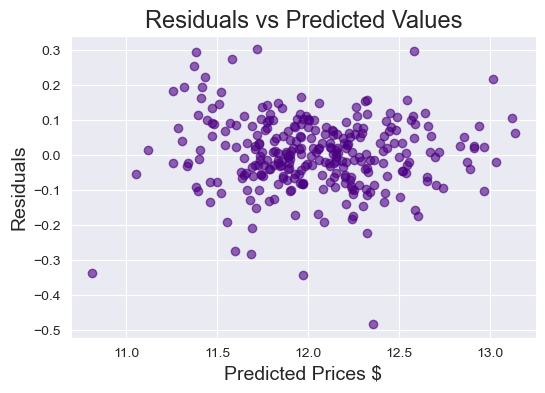

In [175]:
plt.figure(dpi=100)
plt.scatter(x=predictions_2, y=residuals2, c='indigo', alpha=0.6)
plt.title('Residuals vs Predicted Values', fontsize=17)
plt.xlabel('Predicted Prices $', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.show()

### Test Predictions

In [176]:
predictions_test = np.exp(pipeline_2.predict(test))

In [177]:
# Save test predictions to file
output = pd.DataFrame({'Id': test.index,
                       'SalePrice': predictions_test})
output.to_csv('submission.csv', index=False)

In [178]:
#confirm shape before submission
test.shape

(1459, 81)